<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.
import pandas as pd
from pprint import pprint

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape

(1460, 81)

In [3]:
# View a subset of data
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Clean Data - Remove any houses that are not residential from the dataset.

# MSZoning: Identifies the general zoning classification of the sale.
#        A	Agriculture - NO
#        C	Commercial - NO
#        FV	Floating Village Residential - OK
#        I	Industrial - NO
#        RH	Residential High Density - OK
#        RL	Residential Low Density - OK
#        RP	Residential Low Density Park - OK
#        RM	Residential Medium Density - OK
print('*'*20, '\nBefore Cleaning')        
print('Shape of dataframe:', house.shape)
pprint(house.MSZoning.value_counts())

house_clean = house[house.MSZoning.isin(['RH', 'RL', 'RP', 'RM', 'FV'])]

print('\n')
print('*'*20, '\nAfter Cleaning')        
print('Shape of dataframe:', house_clean.shape)
pprint(house_clean.MSZoning.value_counts())

print('\n{nrows_removed} rows removed. '.format(nrows_removed=house.shape[0] - house_clean.shape[0]))

******************** 
Before Cleaning
Shape of dataframe: (1460, 81)
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


******************** 
After Cleaning
Shape of dataframe: (1450, 81)
RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

10 rows removed. 


In [5]:
# Clean Data - Remove columns with mostly null values
print('*'*20, '\nBefore Cleaning')   
print('Number of columns:', len(house_clean.columns),'\n')

n_rows = house_clean.shape[0] 
cut_off_null = 0
for column_name in house_clean.columns:
    n_null_values = house_clean[column_name].isnull().sum()
    percent_null = n_null_values/n_rows
    if percent_null > cut_off_null:
        print('Column {column_name} will be dropped.'.format(column_name=column_name))
        house_clean = house_clean.drop(columns=column_name)
    
print('*'*20, '\nAfter Cleaning')
print('Number of columns:', len(house_clean.columns))

******************** 
Before Cleaning
Number of columns: 81 

Column LotFrontage will be dropped.
Column Alley will be dropped.
Column MasVnrType will be dropped.
Column MasVnrArea will be dropped.
Column BsmtQual will be dropped.
Column BsmtCond will be dropped.
Column BsmtExposure will be dropped.
Column BsmtFinType1 will be dropped.
Column BsmtFinType2 will be dropped.
Column Electrical will be dropped.
Column FireplaceQu will be dropped.
Column GarageType will be dropped.
Column GarageYrBlt will be dropped.
Column GarageFinish will be dropped.
Column GarageQual will be dropped.
Column GarageCond will be dropped.
Column PoolQC will be dropped.
Column Fence will be dropped.
Column MiscFeature will be dropped.
******************** 
After Cleaning
Number of columns: 62


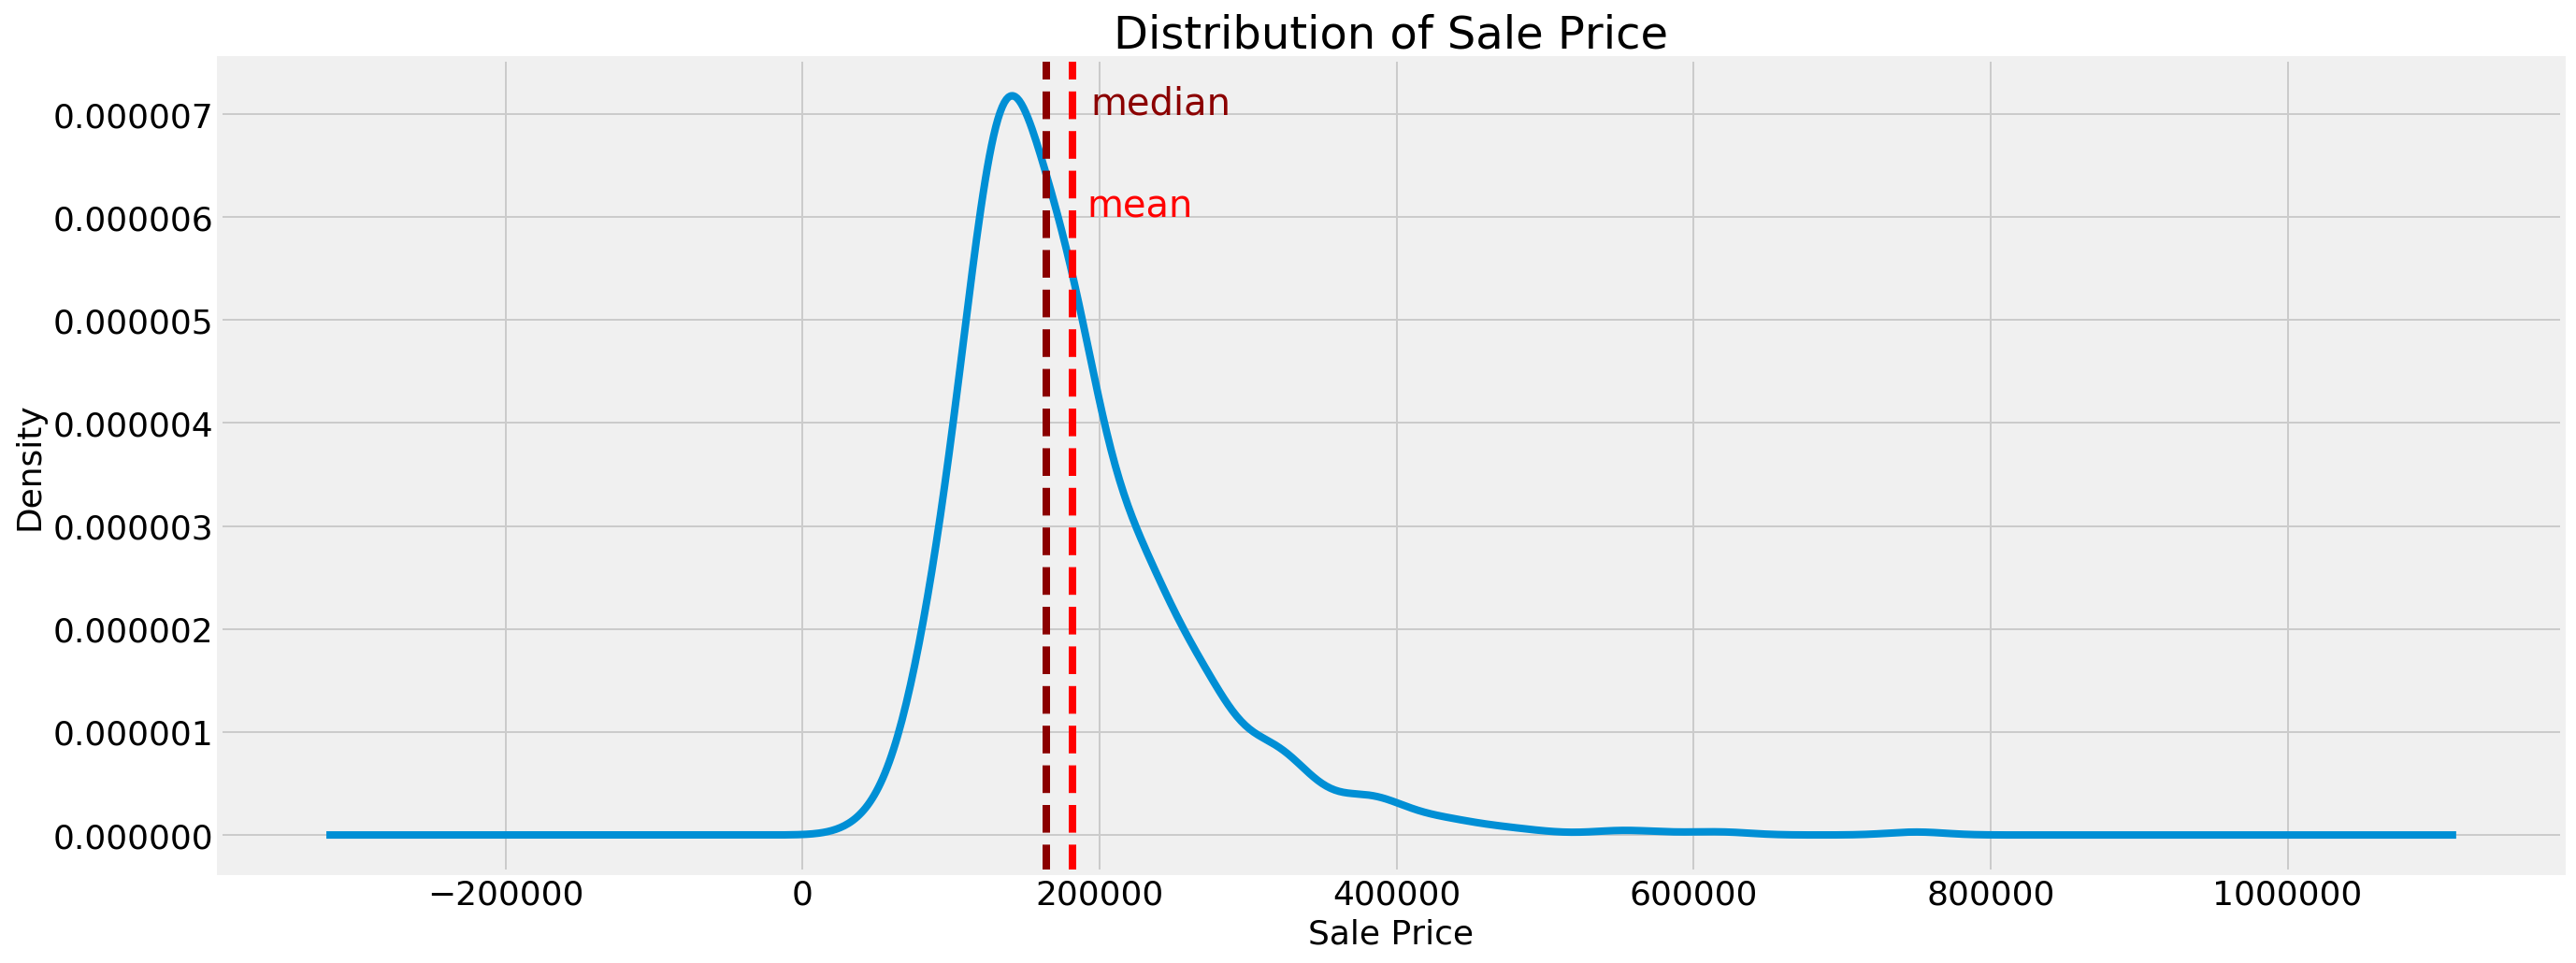

In [6]:
# EDA - Visualise Sale Price
g_mean = house_clean['SalePrice'].mean()
g_median = house_clean['SalePrice'].median()
house_clean['SalePrice'].plot(kind='kde', figsize=(20,8), fontsize=18, linewidth=4)
plt.title('Distribution of Sale Price', fontsize=24);
plt.ylabel('Density', fontsize=18);
plt.xlabel('Sale Price', fontsize=18)
plt.axvline(g_mean, linewidth=4, linestyle='--', color='red')
plt.text(g_mean+10000, 0.000006,'mean', fontsize=20, color='red')
plt.axvline(g_median, linewidth=4, linestyle='--', color='darkred')
plt.text(g_median+30000, 0.000007,'median', fontsize=20, color='darkred');

In [7]:
# Feature Engineering - Build dummy variables for categorical 

house_clean_dummies = house_clean.copy(deep=True)
house_clean_dummies_no_ref = house_clean.copy(deep=True)
print('*'*20, '\nBefore Cleaning')   
print('Number of columns:', len(house_clean_dummies.columns),'\n')

numerical_columns = house_clean_dummies._get_numeric_data().columns

# For Inspection - To ensure i didn't miss any categorical columns labelled using numbers
# for column_name in numerical_columns:
#     n_categories = house_clean_dummies[column_name].nunique() 
#     if n_categories < 10:
#         print(house_clean_dummies[column_name].value_counts())

categorical_columns = [x for x in house_clean_dummies.columns if x not in numerical_columns]
for column_name in categorical_columns:
    # print(house_clean[column_name].value_counts()) # For inspection - To ensure all are indeed categorical 
    house_clean_dummies = pd.concat([house_clean_dummies, pd.get_dummies(house_clean_dummies[column_name], prefix=column_name)], axis=1)
    house_clean_dummies = house_clean_dummies.drop(columns=column_name)
    
    house_clean_dummies_no_ref = pd.concat([house_clean_dummies_no_ref, pd.get_dummies(house_clean_dummies_no_ref[column_name], prefix=column_name, drop_first=True)], axis=1)
    house_clean_dummies_no_ref = house_clean_dummies_no_ref.drop(columns=column_name)

print('*'*20, '\nAfter Cleaning')
print('Number of columns (with reference columns):', len(house_clean_dummies.columns))
print('Number of columns (without reference columns):', len(house_clean_dummies_no_ref.columns))

******************** 
Before Cleaning
Number of columns: 62 

******************** 
After Cleaning
Number of columns (with reference columns): 216
Number of columns (without reference columns): 189


In [8]:
# Filter training data to only non-renovate-able features (house_renovate), house_non_renovate

# Non Renovate-able features: 
    # The neighborhood
    # Square feet
    # Bedrooms, bathrooms
    # Basement and garage space
    
def split_reno_nonreno(original_data, data_with_dummies):
    X_columns = list(original_data.columns)
    X_columns.remove('Id') # doesn't affect Sale Price
    X_columns.remove('SalePrice') # remove target variable

    columns_non_renovate = []
    columns_non_renovate += [x for x in X_columns if x == 'Neighborhood'] # Neighborhood
    columns_non_renovate += [x for x in X_columns if len(x.split('SF')) > 1] # Square feet
    columns_non_renovate += [x for x in X_columns if len(x.split('Area')) > 1] # Space
    columns_non_renovate += [x for x in X_columns if len(x.split('Bedroom')) > 1] # Bedroom
    columns_non_renovate += [x for x in X_columns if len(x.split('Bath')) > 1] # Bath
    columns_non_renovate += [x for x in X_columns if len(x.split('Sale')) > 1] # Sale condition, Sale type
    columns_non_renovate += [x for x in X_columns if len(x.split('Sold')) > 1] # Sale Month, Year

    columns_non_renovate_manual = [
        'MSSubClass', # type of house (including age)
        'MSZoning', # classification of house e.g. density level
        'BldgType', # Type of dwelling - number of floors etc
        'YearBuilt', # Original construction date
        'EnclosedPorch', # Enclosed porch area in square feet
        '3SsnPorch', # Three season porch area in square feet
        'ScreenPorch', # Screen porch area in square feet
    ]
    columns_non_renovate += columns_non_renovate_manual # Manually picked out as non-renovate-able

    # Manually removed after sanity check. Should be able to change the finishing via renovation
    columns_non_renovate.remove('LowQualFinSF') 

    columns_non_renovate = list(set(columns_non_renovate)) # make it unique
    columns_renovate = [x for x in X_columns if x not in columns_non_renovate]

    # Sanity Check
    print('*'*20, '\nNon Renovate-able features')
    pprint(columns_non_renovate, compact=True)
    print('*'*20, '\nRenovate-able features')
    pprint(columns_renovate, compact=True)
    
    cols = []
    for column_non_renovate in columns_non_renovate:
        cols.append(house_clean_dummies[[col for col in house_clean_dummies.columns if col.startswith(column_non_renovate)]])
    df_non_reno = pd.concat(cols, axis=1)

    cols = []
    for column_renovate in columns_renovate:
        cols.append(house_clean_dummies[[col for col in house_clean_dummies.columns if col.startswith(column_renovate)]])
    df_reno = pd.concat(cols, axis=1)
    
    return df_non_reno, df_reno

print('Data containing reference columns')
df_non_reno_dummies, df_reno_dummies = split_reno_nonreno(house_clean, house_clean_dummies)
print('\n')
print('Data not containing reference columns')
df_non_reno_dummies_no_ref, df_reno_dummies_no_ref = split_reno_nonreno(house_clean, house_clean_dummies_no_ref)

Data containing reference columns
******************** 
Non Renovate-able features
['TotalBsmtSF', 'Neighborhood', 'SaleType', 'GarageArea', 'YrSold',
 'ScreenPorch', 'BsmtFullBath', '3SsnPorch', '1stFlrSF', 'LotArea', 'FullBath',
 'PoolArea', 'BsmtFinSF1', 'YearBuilt', 'MoSold', 'EnclosedPorch', 'MSSubClass',
 '2ndFlrSF', 'HalfBath', 'OpenPorchSF', 'SaleCondition', 'BldgType',
 'BsmtFinSF2', 'GrLivArea', 'BedroomAbvGr', 'MSZoning', 'BsmtHalfBath',
 'WoodDeckSF', 'BsmtUnfSF']
******************** 
Renovate-able features
['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual', 'OverallCond',
 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir',
 'LowQualFinSF', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
 'Fireplaces', 'GarageCars', 'PavedDrive', 'MiscVal']


Data not containing reference columns
*

In [9]:
# Set training data as pre-2010 data and testing data on 2010 houses. (X_train, X_test, y_train, y_test)
y_train = house_clean[['SalePrice']][house_clean.YrSold != 2010]['SalePrice'].ravel()
y_test = house_clean[['SalePrice']][house_clean.YrSold == 2010]['SalePrice'].ravel()

df_reno_dummies_train = df_reno_dummies[house_clean.YrSold != 2010]
df_reno_dummies_test = df_reno_dummies[house_clean.YrSold == 2010]

df_reno_dummies_no_ref_train = df_reno_dummies_no_ref[house_clean.YrSold != 2010]
df_reno_dummies_no_ref_test = df_reno_dummies_no_ref[house_clean.YrSold == 2010]

print('df_reno_dummies_train:', df_reno_dummies_train.shape)
print('df_reno_dummies_test:', df_reno_dummies_test.shape)

print('df_reno_dummies_no_ref_train:', df_reno_dummies_no_ref_train.shape)
print('df_reno_dummies_no_ref_test:', df_reno_dummies_no_ref_test.shape)

print('*'*50)
# do the same for dummies without reference columns

df_non_reno_dummies_train = df_non_reno_dummies[house_clean.YrSold != 2010]
df_non_reno_dummies_test = df_non_reno_dummies[house_clean.YrSold == 2010]

df_non_reno_dummies_no_ref_train = df_non_reno_dummies_no_ref[house_clean.YrSold != 2010]
df_non_reno_dummies_no_ref_test = df_non_reno_dummies_no_ref[house_clean.YrSold == 2010]

# prepared for Question 2
print('df_non_reno_dummies_train:', df_non_reno_dummies_train.shape)
print('df_non_reno_dummies_test:', df_non_reno_dummies_test.shape)

print('df_non_reno_dummies_no_ref_train:', df_non_reno_dummies_no_ref_train.shape)
print('df_non_reno_dummies_no_ref_test:', df_non_reno_dummies_no_ref_test.shape)

df_reno_dummies_train: (1278, 146)
df_reno_dummies_test: (172, 146)
df_reno_dummies_no_ref_train: (1278, 146)
df_reno_dummies_no_ref_test: (172, 146)
**************************************************
df_non_reno_dummies_train: (1278, 73)
df_non_reno_dummies_test: (172, 73)
df_non_reno_dummies_no_ref_train: (1278, 73)
df_non_reno_dummies_no_ref_test: (172, 73)


In [10]:
scores = []

scaler_types = ['rb', 'mms', 'mas']

In [11]:
def standardise(X_train, X_test, scaler_type):
    from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
    if scaler_type=='mms':
        scaler = MinMaxScaler()
    if scaler_type=='rb':
        scaler = RobustScaler()
    if scaler_type=='mas':
        scaler = MaxAbsScaler()
        
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [12]:
# linear regression methods to try out: Ridge, Lasso, ElasticNet, SVR(kernel = 'rbf'), Ensemble Regressors
def model_ridge(X_train, y_train, X_test, y_test, scaler_type, X_type):
    from sklearn.linear_model import RidgeCV
    X_train, X_test = standardise(X_train, X_test, scaler_type)
    model = RidgeCV(alphas=np.linspace(0.01, 100, 100), cv=5)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return ['RidgeCV', X_type, X_train.shape[1], scaler_type, score]

for scaler_type in scaler_types:
    for k in range(10, df_non_reno_dummies_train.shape[1], int((df_non_reno_dummies_train.shape[1]-10)/5)): # make sure only run 10 k
        model_kbest = SelectKBest(chi2, k = k)
        result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
        df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
        df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
        selected_true = list(df_selected_true['Selected'].keys())
        results = model_ridge(df_non_reno_dummies_train[selected_true], y_train, df_non_reno_dummies_test[selected_true], y_test, scaler_type, 'original')
        scores.append(results)
        print(results)

        results = model_ridge(df_non_reno_dummies_no_ref_train[selected_true], y_train, df_non_reno_dummies_no_ref_test[selected_true], y_test, scaler_type, 'no_ref')
        scores.append(results)
        print(results)

['RidgeCV', 'original', 10, 'rb', 0.7001304195829549]
['RidgeCV', 'no_ref', 10, 'rb', 0.7001304195829549]
['RidgeCV', 'original', 22, 'rb', 0.7778566059448864]
['RidgeCV', 'no_ref', 22, 'rb', 0.7778566059448864]
['RidgeCV', 'original', 34, 'rb', 0.8162051700049086]
['RidgeCV', 'no_ref', 34, 'rb', 0.8162051700049086]
['RidgeCV', 'original', 46, 'rb', 0.8218565644063643]
['RidgeCV', 'no_ref', 46, 'rb', 0.8218565644063643]
['RidgeCV', 'original', 58, 'rb', 0.8272302317926967]
['RidgeCV', 'no_ref', 58, 'rb', 0.8272302317926967]
['RidgeCV', 'original', 70, 'rb', 0.8417798045157511]
['RidgeCV', 'no_ref', 70, 'rb', 0.8417798045157511]
['RidgeCV', 'original', 10, 'mms', 0.6914785039155981]
['RidgeCV', 'no_ref', 10, 'mms', 0.6914785039155981]
['RidgeCV', 'original', 22, 'mms', 0.7611445954713743]
['RidgeCV', 'no_ref', 22, 'mms', 0.7611445954713743]
['RidgeCV', 'original', 34, 'mms', 0.809469472273461]
['RidgeCV', 'no_ref', 34, 'mms', 0.809469472273461]
['RidgeCV', 'original', 46, 'mms', 0.81331

In [13]:
def model_lasso(X_train, y_train, X_test, y_test, scaler_type, X_type):
    from sklearn.linear_model import LassoCV
    X_train, X_test = standardise(X_train, X_test, scaler_type)
    model = LassoCV(alphas=np.linspace(0.01, 100, 100), cv=5)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return ['LassoCV', X_type, X_train.shape[1], scaler_type, score]

for scaler_type in scaler_types:  
    for k in range(10, df_non_reno_dummies_train.shape[1], int((df_non_reno_dummies_train.shape[1]-10)/5)): # make sure only run 10 k
        model_kbest = SelectKBest(chi2, k = k)
        result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
        df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
        df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
        selected_true = list(df_selected_true['Selected'].keys())
        results = model_lasso(df_non_reno_dummies_train[selected_true], y_train, df_non_reno_dummies_test[selected_true], y_test, scaler_type, 'original')
        scores.append(results)
        print(results)

        results = model_lasso(df_non_reno_dummies_no_ref_train[selected_true], y_train, df_non_reno_dummies_no_ref_test[selected_true], y_test, scaler_type, 'no_ref')
        scores.append(results)
        print(results)

['LassoCV', 'original', 10, 'rb', 0.7032802093823816]
['LassoCV', 'no_ref', 10, 'rb', 0.7032802093823816]
['LassoCV', 'original', 22, 'rb', 0.7733401790695045]
['LassoCV', 'no_ref', 22, 'rb', 0.7733401790695045]
['LassoCV', 'original', 34, 'rb', 0.8149118979329126]
['LassoCV', 'no_ref', 34, 'rb', 0.8149118979329126]
['LassoCV', 'original', 46, 'rb', 0.8202947164174061]
['LassoCV', 'no_ref', 46, 'rb', 0.8202947164174061]
['LassoCV', 'original', 58, 'rb', 0.8243319283967692]
['LassoCV', 'no_ref', 58, 'rb', 0.8243319283967692]
['LassoCV', 'original', 70, 'rb', 0.8403300245566309]
['LassoCV', 'no_ref', 70, 'rb', 0.8403300245566309]
['LassoCV', 'original', 10, 'mms', 0.7041621395817443]
['LassoCV', 'no_ref', 10, 'mms', 0.7041621395817443]
['LassoCV', 'original', 22, 'mms', 0.7681441556319275]
['LassoCV', 'no_ref', 22, 'mms', 0.7681441556319275]
['LassoCV', 'original', 34, 'mms', 0.8114471772722252]
['LassoCV', 'no_ref', 34, 'mms', 0.8114471772722252]
['LassoCV', 'original', 46, 'mms', 0.817

In [14]:
def model_elastic(X_train, y_train, X_test, y_test, scaler_type, X_type):
    from sklearn.linear_model import ElasticNetCV
    X_train, X_test = standardise(X_train, X_test, scaler_type)
    model = ElasticNetCV(alphas=np.linspace(0.01, 100, 100), cv=5)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return ['ElasticNetCV', X_type, X_train.shape[1], scaler_type, score]

for scaler_type in scaler_types:
    for k in range(10, df_non_reno_dummies_train.shape[1], int((df_non_reno_dummies_train.shape[1]-10)/5)): # make sure only run 10 k
        model_kbest = SelectKBest(chi2, k = k)
        result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
        df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
        df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
        selected_true = list(df_selected_true['Selected'].keys())
        results = model_elastic(df_non_reno_dummies_train[selected_true], y_train, df_non_reno_dummies_test[selected_true], y_test, scaler_type, 'original')
        scores.append(results)
        print(results)

        results = model_elastic(df_non_reno_dummies_no_ref_train[selected_true], y_train, df_non_reno_dummies_no_ref_test[selected_true], y_test, scaler_type, 'no_ref')
        scores.append(results)
        print(results)

['ElasticNetCV', 'original', 10, 'rb', 0.7036823238424046]
['ElasticNetCV', 'no_ref', 10, 'rb', 0.7036823238424046]
['ElasticNetCV', 'original', 22, 'rb', 0.7780010052251268]
['ElasticNetCV', 'no_ref', 22, 'rb', 0.7780010052251268]
['ElasticNetCV', 'original', 34, 'rb', 0.8210723249091711]
['ElasticNetCV', 'no_ref', 34, 'rb', 0.8210723249091711]
['ElasticNetCV', 'original', 46, 'rb', 0.8243491707696231]
['ElasticNetCV', 'no_ref', 46, 'rb', 0.8243491707696231]
['ElasticNetCV', 'original', 58, 'rb', 0.8295874944843395]
['ElasticNetCV', 'no_ref', 58, 'rb', 0.8295874944843395]
['ElasticNetCV', 'original', 70, 'rb', 0.8426559401668554]
['ElasticNetCV', 'no_ref', 70, 'rb', 0.8426559401668554]
['ElasticNetCV', 'original', 10, 'mms', 0.6121567464967927]
['ElasticNetCV', 'no_ref', 10, 'mms', 0.6121567464967927]
['ElasticNetCV', 'original', 22, 'mms', 0.7389953945669934]
['ElasticNetCV', 'no_ref', 22, 'mms', 0.7389953945669934]
['ElasticNetCV', 'original', 34, 'mms', 0.792770796640097]
['Elastic

In [15]:
def model_bagging(X_train, y_train, X_test, y_test, scaler_type, X_type):
#     X_train = standardise(X_train, X_test, scaler_type)
    from sklearn.ensemble import BaggingRegressor
    model = BaggingRegressor()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return ['BaggingRegressor', X_type, X_train.shape[1], scaler_type, score]

for scaler_type in scaler_types:  
    for k in range(10, df_non_reno_dummies_train.shape[1], int((df_non_reno_dummies_train.shape[1]-10)/5)): # make sure only run 10 k
        model_kbest = SelectKBest(chi2, k = k)
        result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
        df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
        df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
        selected_true = list(df_selected_true['Selected'].keys())
        results = model_bagging(df_non_reno_dummies_train[selected_true], y_train, df_non_reno_dummies_test[selected_true], y_test, scaler_type, 'original')
        scores.append(results)
        print(results)

        results = model_bagging(df_non_reno_dummies_no_ref_train[selected_true], y_train, df_non_reno_dummies_no_ref_test[selected_true], y_test, scaler_type, 'no_ref')
        scores.append(results)
        print(results)

['BaggingRegressor', 'original', 10, 'rb', 0.7284479279527873]
['BaggingRegressor', 'no_ref', 10, 'rb', 0.7951255524346051]
['BaggingRegressor', 'original', 22, 'rb', 0.8125548455182738]
['BaggingRegressor', 'no_ref', 22, 'rb', 0.8274642722684765]
['BaggingRegressor', 'original', 34, 'rb', 0.8050229576593865]
['BaggingRegressor', 'no_ref', 34, 'rb', 0.8360225653694784]
['BaggingRegressor', 'original', 46, 'rb', 0.8089609136646125]
['BaggingRegressor', 'no_ref', 46, 'rb', 0.8313666220578477]
['BaggingRegressor', 'original', 58, 'rb', 0.8522667887534487]
['BaggingRegressor', 'no_ref', 58, 'rb', 0.8641041900627133]
['BaggingRegressor', 'original', 70, 'rb', 0.8589778512497868]
['BaggingRegressor', 'no_ref', 70, 'rb', 0.87956211308102]
['BaggingRegressor', 'original', 10, 'mms', 0.7345420857805187]
['BaggingRegressor', 'no_ref', 10, 'mms', 0.7428795235098912]
['BaggingRegressor', 'original', 22, 'mms', 0.8101283478121694]
['BaggingRegressor', 'no_ref', 22, 'mms', 0.8366085561450147]
['Bagg

In [16]:
def model_svr(X_train, y_train, X_test, y_test, scaler_type, X_type):
    from sklearn.svm import SVR
    X_train, X_test = standardise(X_train, X_test, scaler_type)
    model = SVR(kernel='rbf')
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return ['SVR_rbf', X_type, X_train.shape[1], scaler_type, score]

for scaler_type in scaler_types:
    for k in range(10, df_non_reno_dummies_train.shape[1], int((df_non_reno_dummies_train.shape[1]-10)/5)): # make sure only run 10 k
        model_kbest = SelectKBest(chi2, k = k)
        result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
        df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
        df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
        selected_true = list(df_selected_true['Selected'].keys())
        results = model_svr(df_non_reno_dummies_train[selected_true], y_train, df_non_reno_dummies_test[selected_true], y_test, scaler_type, 'original')
        scores.append(results)
        print(results)

        results = model_svr(df_non_reno_dummies_no_ref_train[selected_true], y_train, df_non_reno_dummies_no_ref_test[selected_true], y_test, scaler_type, 'no_ref')
        scores.append(results)
        print(results)

['SVR_rbf', 'original', 10, 'rb', -0.030967405987696095]
['SVR_rbf', 'no_ref', 10, 'rb', -0.030967405987696095]
['SVR_rbf', 'original', 22, 'rb', -0.031211316745493045]
['SVR_rbf', 'no_ref', 22, 'rb', -0.031211316745493045]
['SVR_rbf', 'original', 34, 'rb', -0.03129637888651926]
['SVR_rbf', 'no_ref', 34, 'rb', -0.03129637888651926]
['SVR_rbf', 'original', 46, 'rb', -0.031328219699420234]
['SVR_rbf', 'no_ref', 46, 'rb', -0.031328219699420234]
['SVR_rbf', 'original', 58, 'rb', -0.03134783514394446]
['SVR_rbf', 'no_ref', 58, 'rb', -0.03134783514394446]
['SVR_rbf', 'original', 70, 'rb', -0.03132822889827014]
['SVR_rbf', 'no_ref', 70, 'rb', -0.03132822889827014]
['SVR_rbf', 'original', 10, 'mms', -0.03174060449771887]
['SVR_rbf', 'no_ref', 10, 'mms', -0.03174060449771887]
['SVR_rbf', 'original', 22, 'mms', -0.0317342036136945]
['SVR_rbf', 'no_ref', 22, 'mms', -0.0317342036136945]
['SVR_rbf', 'original', 34, 'mms', -0.031758374610574513]
['SVR_rbf', 'no_ref', 34, 'mms', -0.031758374610574513

In [17]:
model_performances = pd.DataFrame(scores, columns=['Model', 'X_type', 'k', 'scaler_type', 'R2']).sort_values(by='R2')[::-1]
model_performances.head()

,Model,X_type,k,scaler_type,R2
119,BaggingRegressor,no_ref,70,rb,0.879562
130,BaggingRegressor,original,70,mms,0.871394
117,BaggingRegressor,no_ref,58,rb,0.864104
131,BaggingRegressor,no_ref,70,mms,0.862989
118,BaggingRegressor,original,70,rb,0.858978


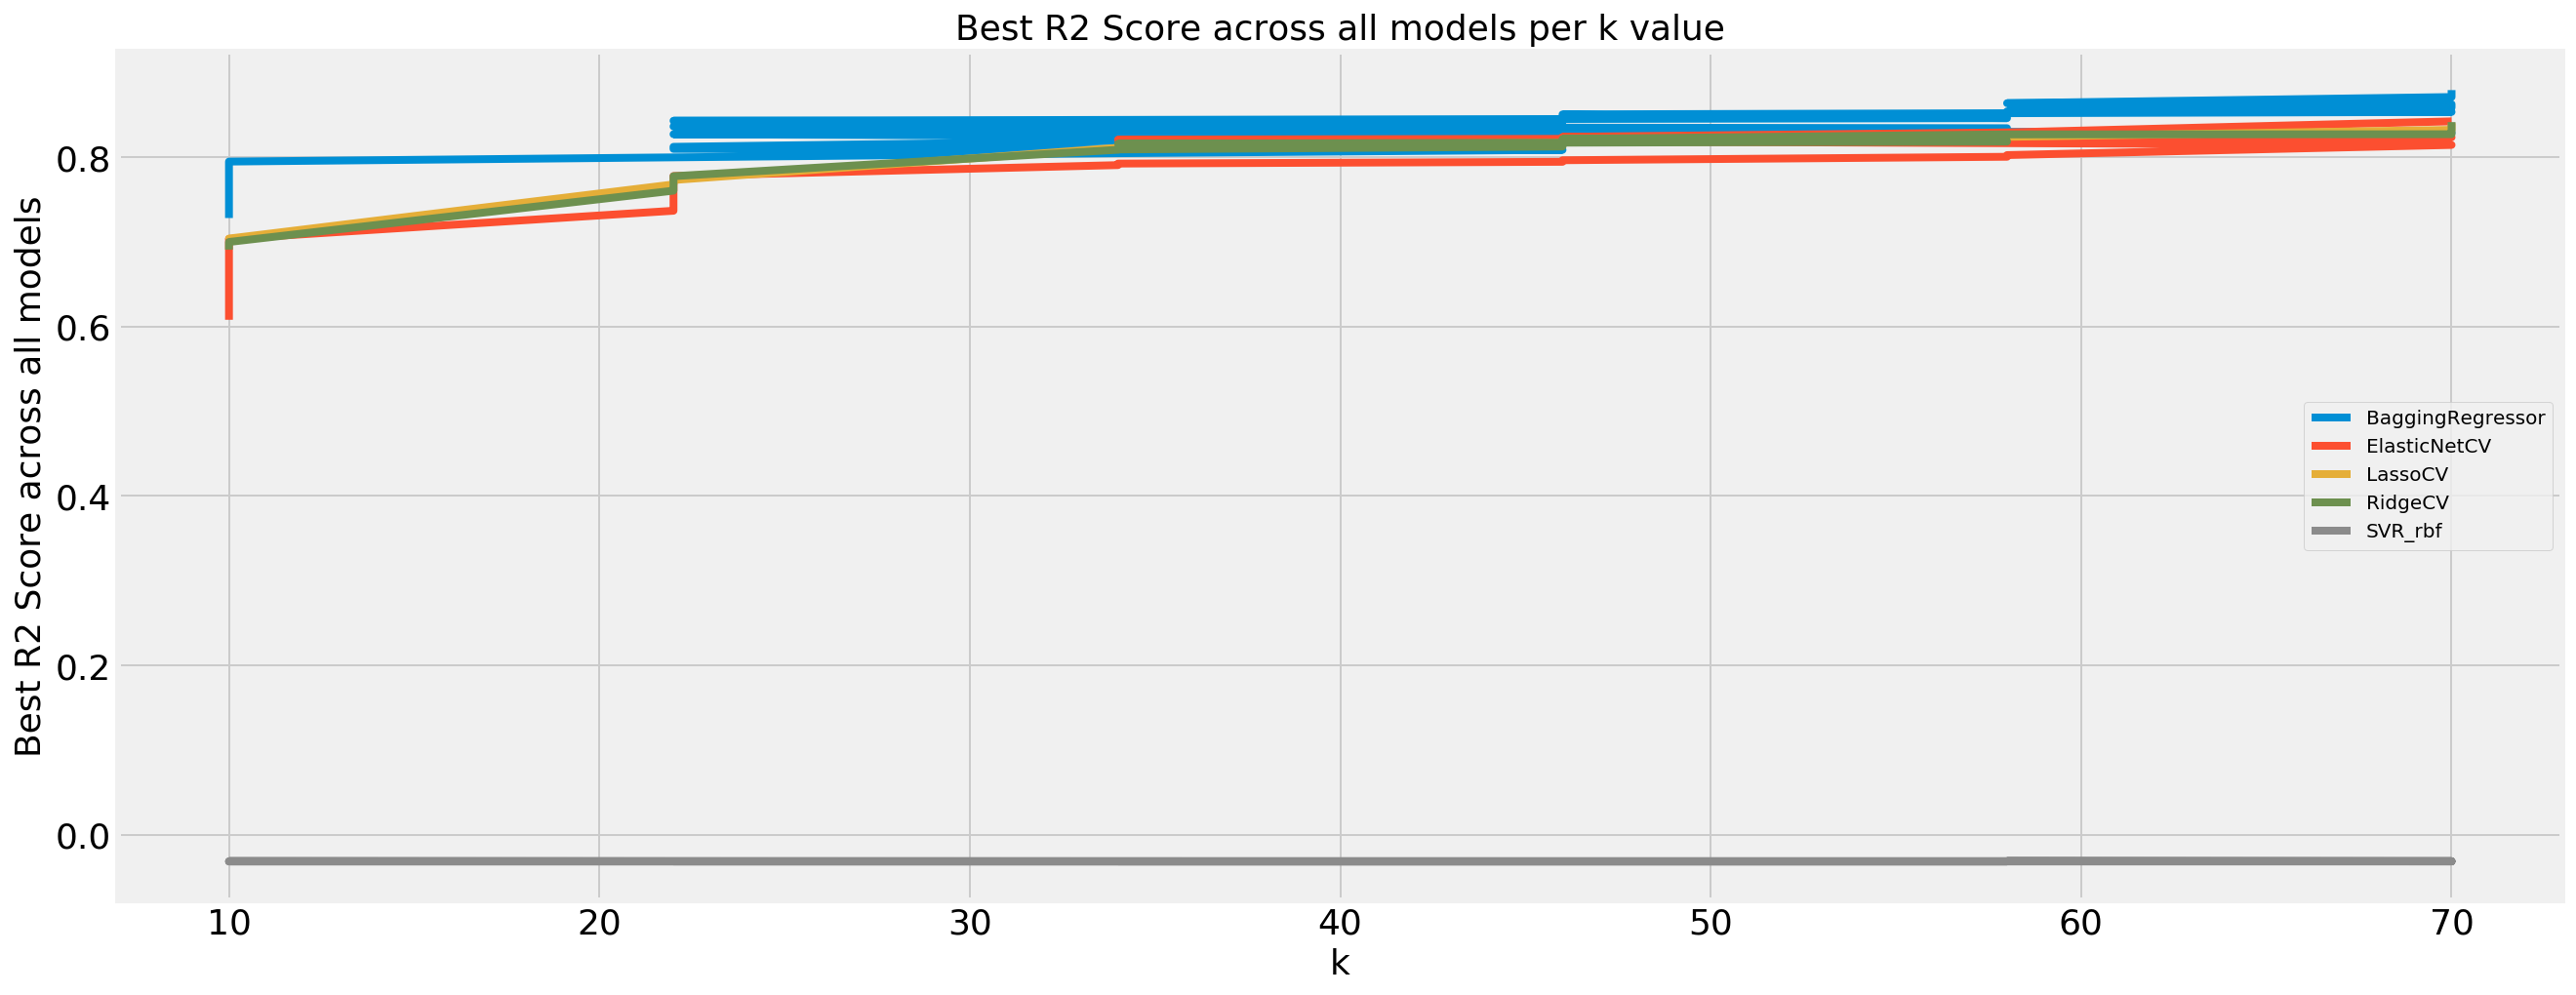

In [18]:
performance_by_model = model_performances.groupby(by=['Model'])
fig, ax = plt.subplots()
for key,grp in performance_by_model:
    grp.plot(kind='line', x='k', y='R2', figsize=(20,8),fontsize=18, label=key, ax=ax)
plt.legend()
plt.xlabel('k', fontsize=18)
plt.ylabel('Best R2 Score across all models', fontsize=18)
plt.title('Best R2 Score across all models per k value', fontsize=18);

> We can see that higher k gave higher R2 scores.

,X_type,k,scaler_type,R2
Model,,,,
BaggingRegressor,original,70,rb,0.879562


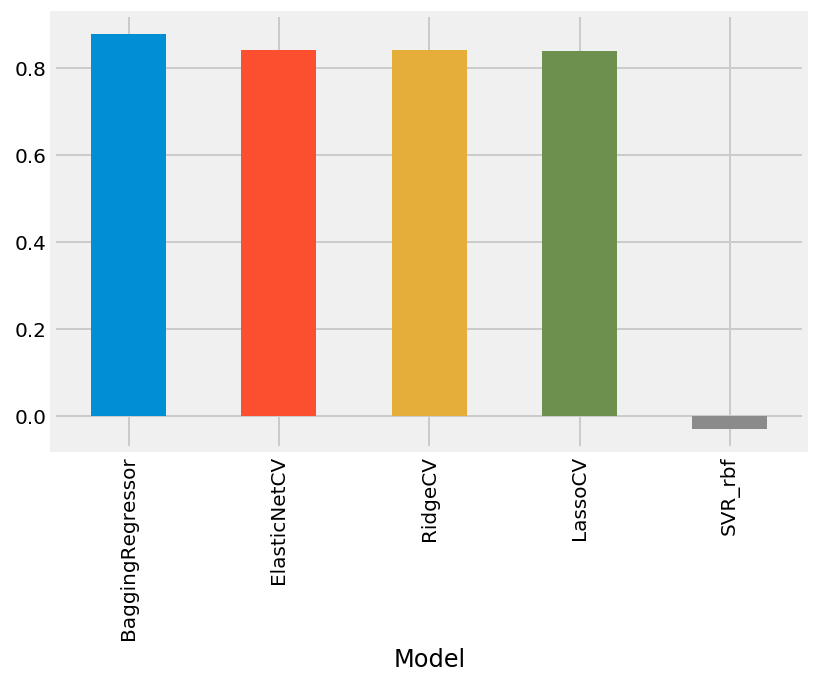

In [19]:
performance_by_model.max()['R2'].sort_values()[::-1].plot(kind='bar')
performance_by_model.max().sort_values(by='R2')[::-1].head(1)

> We can see that BaggingRegressor gave the highest score of 0.87

In [20]:
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor()

model_kbest = SelectKBest(chi2, k = 70)
result_kbest = model_kbest.fit_transform(df_non_reno_dummies_train,y_train)
df_features_selected = pd.DataFrame(model_kbest.get_support(), index=df_non_reno_dummies_train.columns, columns=['Selected'])
df_selected_true = df_features_selected[df_features_selected['Selected'] == True]
selected_true = list(df_selected_true['Selected'].keys())

model.fit(df_non_reno_dummies_train[selected_true], y_train)
y_predict_fixed_features = model.predict(df_non_reno_dummies_test[selected_true])

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_predict_fixed_features)
r2 = r2_score(y_test, y_predict_fixed_features)

print('mse:',mse)
print('r2:', r2)

mse: 1053505315.1299419
r2: 0.8342867423934801


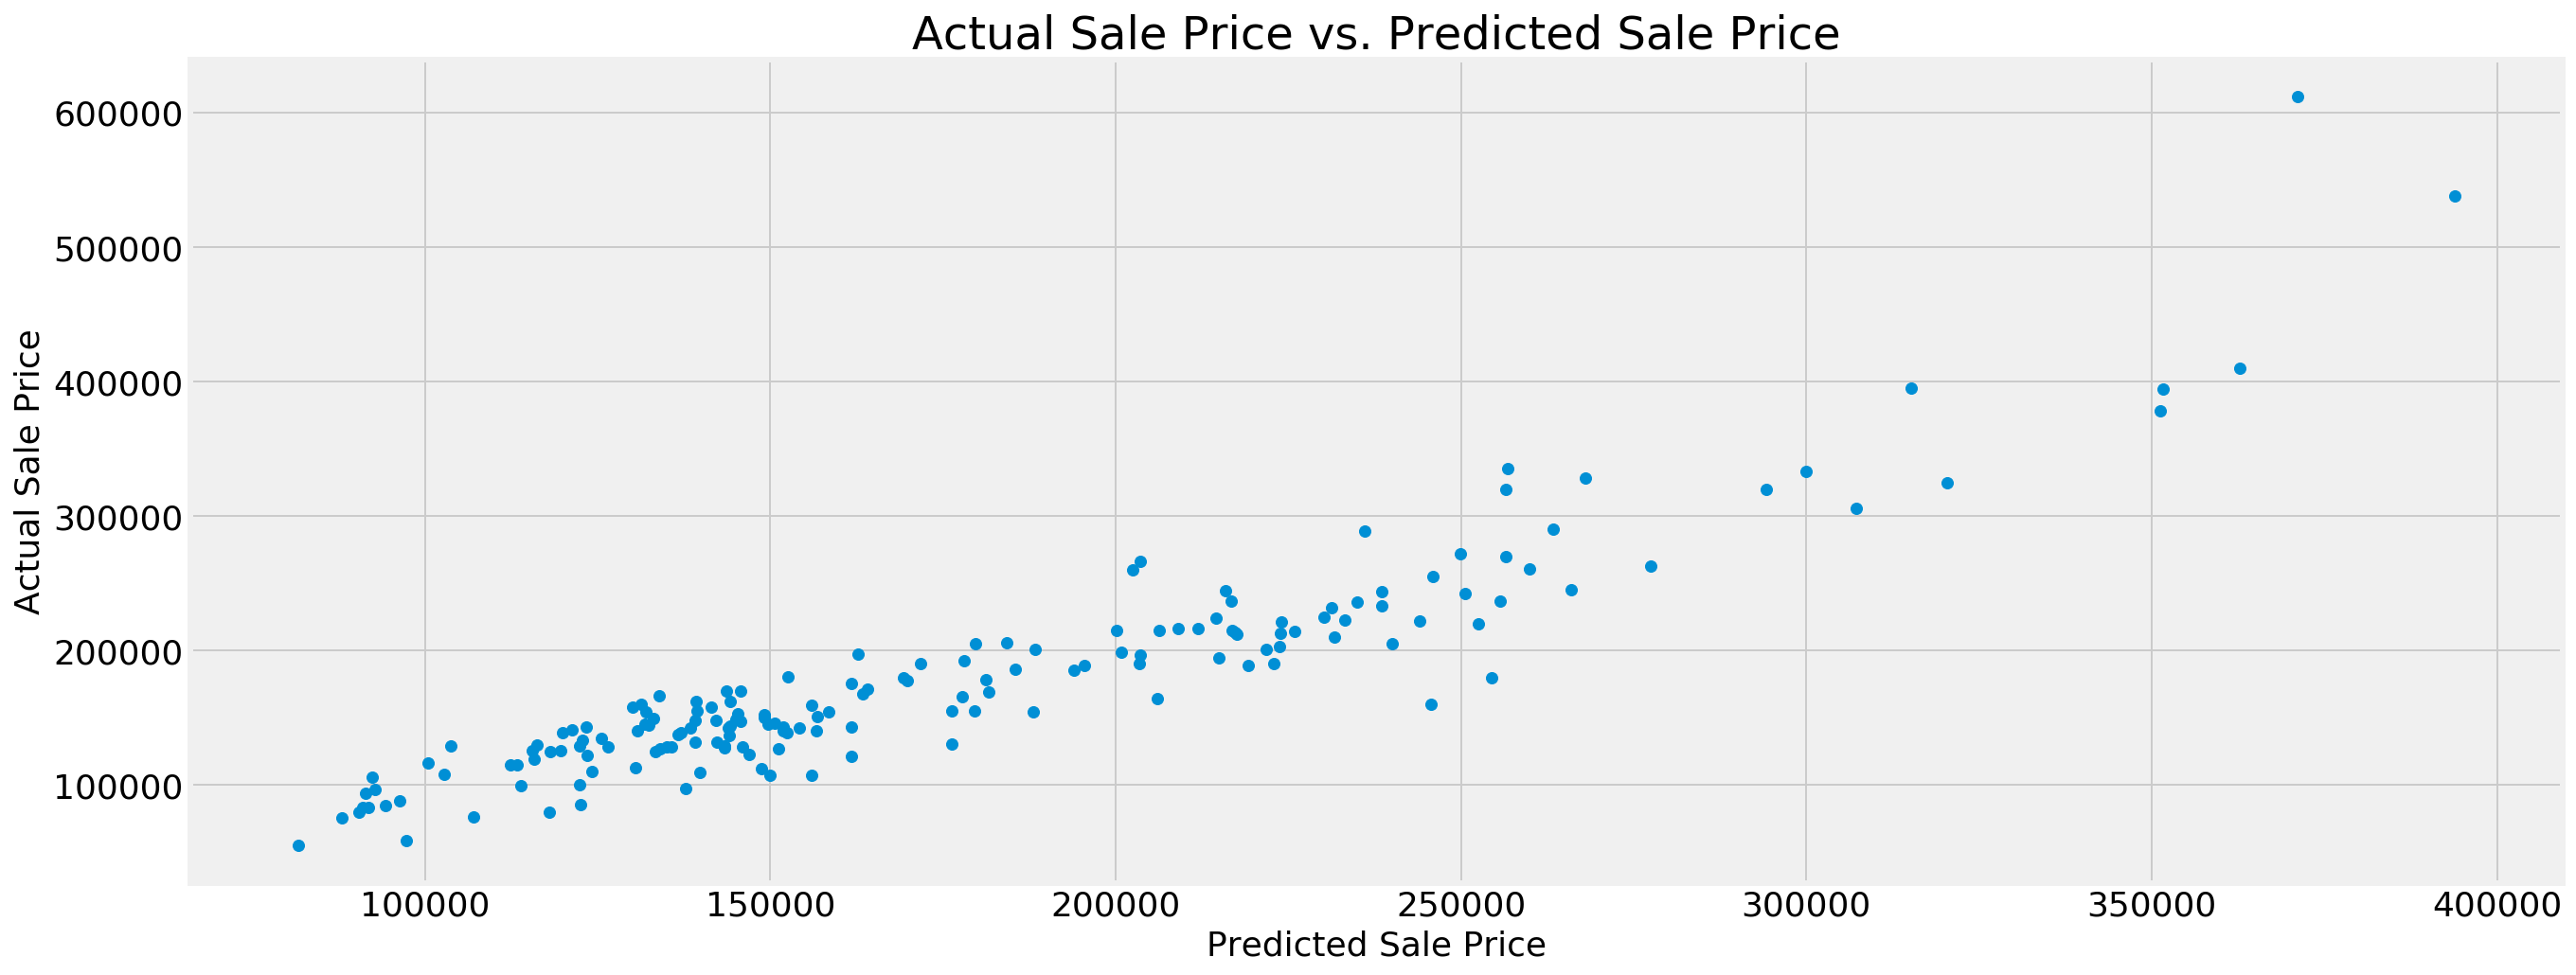

In [22]:
# scatter plot: y_prediction vs. y_actual
plt.figure(figsize=(20,8))
plt.scatter(x=y_predict_fixed_features, y=y_test)
plt.xlabel('Predicted Sale Price', fontsize=18)
plt.ylabel('Actual Sale Price', fontsize=18)
plt.title('Actual Sale Price vs. Predicted Sale Price', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=18)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [23]:
# concat renovate-able features with non-renovate-able features
df_X = pd.concat([df_reno_dummies, df_non_reno_dummies], axis=1)
df_X_train = df_X[house_clean.YrSold != 2010]
df_X_test = df_X[house_clean.YrSold == 2010]
print(df_X_train.shape)
print(df_X_test.shape)

(1278, 219)
(172, 219)


In [24]:
from sklearn.linear_model import ElasticNet # Use elasticnet because bagging has no coefficients
model_elastic_all_features = ElasticNet(alpha=0.01)
model_elastic_all_features.fit(df_X_train, y_train)
y_predict_all_features = model_elastic_all_features.predict(df_X_test)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_predict_all_features)
r2 = r2_score(y_test, y_predict_all_features)

print('mse:',mse)
print('r2:', r2)

mse: 662758414.453452
r2: 0.8957500695175257


In [26]:
df_coef = (pd.DataFrame([model_elastic_all_features.coef_, df_X_train.columns]).T)
df_coef = df_coef.rename(columns={0:'Coefficients', 1:'Feature'})
df_coef['Coefficients_Strength'] = df_coef['Coefficients'].map(lambda x:abs(int(x)) if x != None else None)
df_coef['Renovate-able'] = df_coef['Feature'].map(lambda x:True if x in df_reno_dummies.columns else False)
df_coef_details = df_coef.sort_values(by='Coefficients_Strength')[::-1]

In [27]:
# Evaluate the effect in dollars of the renovate-able features.
def print_effect(x):
    if x['Coefficients']> 1:
        print('When',x['Feature'], 'increases by 1, Sale Price increases by $', int(x['Coefficients']))
    else:
        print('When',x['Feature'], 'increases by 1, Sale Price decreases by $', abs(int(x['Coefficients'])))
df_coef_details[df_coef_details['Renovate-able'] == True][['Feature', 'Coefficients']].apply(print_effect, axis=1);

When RoofMatl_ClyTile increases by 1, Sale Price decreases by $ 49561
When RoofMatl_WdShngl increases by 1, Sale Price increases by $ 42561
When Condition2_PosN increases by 1, Sale Price decreases by $ 32927
When KitchenQual_Ex increases by 1, Sale Price increases by $ 18292
When Exterior2nd_ImStucc increases by 1, Sale Price increases by $ 18164
When Condition2_Norm increases by 1, Sale Price increases by $ 15669
When LotShape_IR3 increases by 1, Sale Price decreases by $ 14473
When Functional_Typ increases by 1, Sale Price increases by $ 13984
When ExterQual_Ex increases by 1, Sale Price increases by $ 13727
When Exterior1st_BrkFace increases by 1, Sale Price increases by $ 13026
When LandContour_Bnk increases by 1, Sale Price decreases by $ 12583
When LotConfig_CulDSac increases by 1, Sale Price increases by $ 11694
When GarageCars increases by 1, Sale Price increases by $ 11589
When OverallQual increases by 1, Sale Price increases by $ 11310
When HouseStyle_2Story increases by 1, 

In [28]:
# Q: How would your company use this second model and its coefficients to determine whether they should buy a property or not? 
df_coef = (pd.DataFrame([model_elastic_all_features.coef_, df_X_train.columns]).T)
df_coef = df_coef.rename(columns={0:'Coefficients', 1:'Feature'})
df_coef['Renovate-able'] = df_coef['Feature'].map(lambda x:True if x in df_reno_dummies.columns else False)
df_coef_details = df_coef.sort_values(by='Coefficients')[::-1]
df_coef_details[df_coef_details['Renovate-able'] == True].head(3)

# A: By looking at the top coefficients of the model, the company can see whether 
    # 1. a house's roof can be renovated to be of Wood Shingles material
    # 2. a house's kitchen can be upgraded to grade Excellent, abd 
    # 3. 2nd exterior material can be changed to Imitation Stucco
# as these are the renovate-able factors that can greatly affect sale price.

,Coefficients,Feature,Renovate-able
61,42561.9,RoofMatl_WdShngl,True
128,18292.7,KitchenQual_Ex,True
84,18164.2,Exterior2nd_ImStucc,True


In [29]:
# Q: Explain how the company can use the two models you have built to determine if they can make money.
# A: 
    # If the company does not intend to do any renovation, 
    # we can use model 1 to purchase houses that are undervalued (buyer selling at lower price than our predicted values)
    
    # If the company is ok with doing renovation,
    # we can use model 2 to predict prices of the house before and after the specific intended renovation steps
    # and ensure that renovation costs are less than increase in sale price of house after renovation.

In [30]:
# Q: Investigate how much of the variance in price remaining is explained by these features.
# A: 89 % of variance in price is explained by these features.

# Q: Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
# A: As the R2 is very high (0.89), I trust my model. It should be used to evaluate which properties to buy and fix up.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [31]:
y_predict_salecondition = [x for x in house_clean_dummies.columns if len(x.split('SaleCondition')) > 1]
y_predict_salecondition

['SaleCondition_Abnorml',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial']

In [32]:
y_predict_abnormal = house_clean_dummies['SaleCondition_Abnorml']
y_predict_abnormal.value_counts()

0    1354
1      96
Name: SaleCondition_Abnorml, dtype: int64

In [33]:
X_salecondition = house_clean_dummies[[x for x in house_clean_dummies if x not in y_predict_salecondition]]
X_salecondition_train = X_salecondition[X_salecondition.YrSold != 2010]
X_salecondition_test = X_salecondition[X_salecondition.YrSold == 2010]

y_actual_abnormal_train = y_predict_abnormal[X_salecondition.YrSold != 2010]
y_actual_abnormal_test = y_predict_abnormal[X_salecondition.YrSold == 2010]

In [34]:
def determine_what_affect_abnormal_sales(y_predict_abnormal):
    from sklearn.linear_model import ElasticNet # Use elasticnet because bagging has no coefficients
    model_elastic_all_features = ElasticNet(alpha=0.01)
    model_elastic_all_features.fit(X_salecondition_train, y_actual_abnormal_train)
    y_predict_abnormal = model_elastic_all_features.predict(X_salecondition_test)
    
    from sklearn.metrics import mean_squared_error, r2_score
    mse = mean_squared_error(y_actual_abnormal_test, y_predict_abnormal)
    r2 = r2_score(y_actual_abnormal_test, y_predict_abnormal)

    print('mse:',mse)
    print('r2:', r2)
    
    return pd.DataFrame([model_elastic_all_features.coef_, X_salecondition_train]).T.rename(columns={0: 'coefficient', 1: 'Predictor'}).sort_values(by='coefficient')[::-1]

In [35]:
determine_what_affect_abnormal_sales(y_predict_abnormal)

mse: 0.04847040223871006
r2: 0.022530075098842195


,coefficient,Predictor
201,0.23963,SaleType_COD
51,0.00385007,LotConfig_Corner
32,0.0015023,MoSold
30,0.000256045,PoolArea
13,0.000225248,LowQualFinSF
27,0.000214646,EnclosedPorch
29,0.000187034,ScreenPorch
5,0.00016642,YearBuilt
28,0.000150894,3SsnPorch
1,0.000101738,MSSubClass


In [36]:
# r2: 0.022530075098842195 is not good enough. let's do undersampling

In [37]:
df_abnormal_true = house_clean_dummies[house_clean_dummies['SaleCondition_Abnorml'] == 1]
df_abnormal_true.shape

(96, 216)

In [38]:
df_abnormal_false = house_clean_dummies[house_clean_dummies['SaleCondition_Abnorml'] == 0][:df_abnormal_true.shape[0]]
df_abnormal_false.shape

(96, 216)

In [39]:
df_abnormal = pd.concat([df_abnormal_true, df_abnormal_false], axis=0)
df_abnormal.shape

(192, 216)

In [40]:
df_abnormal.SaleCondition_Abnorml.value_counts()

1    96
0    96
Name: SaleCondition_Abnorml, dtype: int64

In [41]:
df_abnormal_train = df_abnormal[df_abnormal['YrSold'] != 2010]
df_abnormal_test = df_abnormal[df_abnormal['YrSold'] == 2010]

In [42]:
df_abnormal_train_y = df_abnormal_train['SaleCondition_Abnorml']
df_abnormal_test_y = df_abnormal_test['SaleCondition_Abnorml']

In [43]:
df_abnormal_train_X = df_abnormal_train[[x for x in df_abnormal_train.columns if x not in y_predict_salecondition]]
df_abnormal_test_X = df_abnormal_test[[x for x in df_abnormal_test.columns if x not in y_predict_salecondition]]

In [44]:
from sklearn.linear_model import ElasticNet # Use elasticnet because bagging has no coefficients
model_elastic_all_features = ElasticNet(alpha=0.01)
model_elastic_all_features.fit(df_abnormal_train_X, df_abnormal_train_y)
y_predict_abnormal = model_elastic_all_features.predict(df_abnormal_test_X)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(df_abnormal_test_y, y_predict_abnormal)
r2 = r2_score(df_abnormal_test_y, y_predict_abnormal)

print('mse:',mse)
print('r2:', r2)

mse: 0.1222030347347598
r2: 0.46007025176014626


In [45]:
df_coefs = pd.DataFrame([model_elastic_all_features.coef_, df_abnormal_train_X.columns]).T.rename(columns={0: 'score', 1:'predictor'})
df_coefs['score'] = df_coefs['score'].map(abs)
df_coefs.sort_values(by='score')[::-1].head()

,score,predictor
158,0.229505,Exterior2nd_Wd Shng
15,0.078917,BsmtFullBath
209,0.056808,SaleType_WD
168,0.053239,Foundation_BrkTil
190,0.048389,KitchenQual_TA


In [46]:
# Q: Determine which features predict the Abnorml category in the SaleCondition feature.
# Justify your results.

# A:
    # Features Exterior2nd_WdShng, BsmtFullbath and SaleType_WD best predicts the abonrml category in the sale condition feature.
    # that is because their absolute coefficients are highest in the elasticnet model. 